In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

import sys
sys.path.append("../") # go to parent dir

import numpy as np
import torch
import matplotlib.pyplot as plt
import mpmath
import networkx as nx

from metal.label_model import LabelModel
from metal.label_model.learn_deps import DependencyLearner

from metal.label_model.graph_utils import generate_edges
from metal.label_model.graph_utils import JunctionTree
from metal.label_model.graph_utils import DependenciesGraph
from synthetic.generate_spa import (
    ChainDependencies,
    TreeDependencies,
    ClusterDependencies,
    DataGenerator
)
from metal.label_model.utils import (
    compute_mu,
    compute_covariance,
    compute_inv_covariance,
    print_matrix,
    visualize_matrix
)

np.random.random(1234)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


/dfs/scratch0/paroma/metal/metal/analysis.py:13: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

The backend was *originally* set to 'module://ipykernel.pylab.backend_inline' by the following code:
  File "/dfs/scratch0/paroma/anaconda2/envs/metal/lib/python3.6/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/dfs/scratch0/paroma/anaconda2/envs/metal/lib/python3.6/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/dfs/scratch0/paroma/anaconda2/envs/metal/lib/python3.6/site-packages/ipykernel/__main__.py", line 3, in <module>
    app.launch_new_instance()
  File "/dfs/scratch0/paroma/anaconda2/envs/metal/lib/python3.6/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/dfs/scratch0/paroma/anaconda2/envs/metal/lib/py

array([0.11458959, 0.71646039, 0.7359136 , ..., 0.35584801, 0.01433044,
       0.704642  ])

## Generate Data by Passing in Edge List

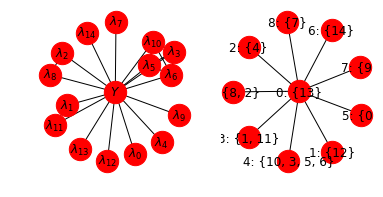

In [2]:
M = 15
N = 10000
N_CLUSTERS = M-1
EDGE_PROB = 1.0
K = 2
HIGHER_ORDER_CLIQUES = False

# Set Graph Structure
deps_graph = ClusterDependencies(M, N_CLUSTERS, edge_prob=EDGE_PROB)
plt.figure(figsize=(6,3))
plt.subplot(1,2,1)
deps_graph.draw()


#Generate Data
data = DataGenerator(
    N,
    M,
    k=K,
    abstains=False,
    deps_graph=deps_graph,
    higher_order_cliques=HIGHER_ORDER_CLIQUES
)
plt.subplot(1,2,2)
data.jt.draw()

#get true values for later comparison, label model
#sigma_O = data.get_sigma_O()
#E_O = np.array([data.P_marginal(v) for i, v in data.jt.iter_observed()])
class_balance = data.get_class_balance()
L,Y = data.generate_label_matrix(N)

## Train LabelModel with No Dependencies

In [3]:
#Create junction tree with no dependencies between LFs
edges_ind = []
for i in range(M):
    edges_ind.append((i,M))

jt_ind = JunctionTree(
            M,
            K,
            abstains=False,
            edges=edges_ind,
            higher_order_cliques=HIGHER_ORDER_CLIQUES
        )

lm = LabelModel(k=2)
lm.train(
    L_train = L,
    junction_tree=jt_ind,
    class_balance=class_balance,
    lr=0.0005,
    n_epochs=10000,
    print_every=1000
)

mu = data.get_mu()
np.mean(np.abs(lm.mu - mu))

Estimating Z...
[E:0]	Train Loss: 110.449
[E:1000]	Train Loss: 0.912
[E:2000]	Train Loss: 0.855
[E:3000]	Train Loss: 0.838
[E:4000]	Train Loss: 0.829
[E:5000]	Train Loss: 0.823
[E:6000]	Train Loss: 0.819
[E:7000]	Train Loss: 0.816
[E:8000]	Train Loss: 0.813
[E:9000]	Train Loss: 0.812
[E:9999]	Train Loss: 0.810
Finished Training


0.0303616780954057

## Dependency Learning with RPCA

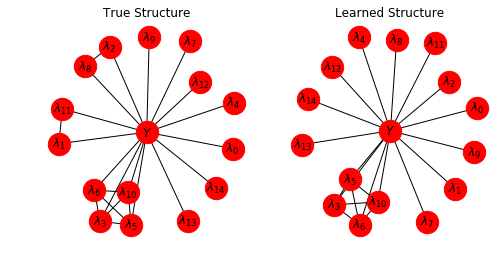

In [7]:
sigma_O_from_L = (np.dot(L.T,L))/(N-1) -  \
    np.outer(np.mean(L,axis=0), np.mean(L,axis=0))
sigma_O_inv = np.linalg.inv(sigma_O_from_L)
dl = DependencyLearner(M,sigma_O_inv)
edges_est = dl.edges_from_rpca(thresh=0.15)

deps_graph_est = DependenciesGraph(M, edges_est)
plt.figure(figsize=(8,4))
plt.subplot(1,2,1)
plt.title('True Structure')
deps_graph.draw()
plt.subplot(1,2,2)
plt.title('Learned Structure')
deps_graph_est.draw()

In [8]:
for i in range(M):
    edges_est.append((i,M))

jt_est = JunctionTree(
            M,
            K,
            abstains=False,
            edges=edges_est,
            higher_order_cliques=HIGHER_ORDER_CLIQUES
        )

lm_deps = LabelModel(k=2)
lm_deps.train(
    L_train = L,
    junction_tree=jt_est,
    class_balance=class_balance,
    lr=0.001,
    n_epochs=10000,
    print_every=1000
)

mu = data.get_mu()
print ('Without deps: ', np.mean(np.abs(lm.mu - mu)))
print ('With deps   : ', np.mean(np.abs(lm_deps.mu - mu)))

Estimating Z...
[E:0]	Train Loss: 216.231
[E:1000]	Train Loss: 0.225
[E:2000]	Train Loss: 0.225
[E:3000]	Train Loss: 0.225
[E:4000]	Train Loss: 0.225
[E:5000]	Train Loss: 0.225
[E:6000]	Train Loss: 0.225
[E:7000]	Train Loss: 0.225
[E:8000]	Train Loss: 0.225
[E:9000]	Train Loss: 0.225
[E:9999]	Train Loss: 0.225
Finished Training
Without deps:  0.0303616780954057
With deps   :  0.005948786125971642
